## Sort a list using a neural network

Input: A list of numbers.

Output: A sorted list of the same numbers.

Treat the list as a fully connected directed graph where each node represents a number.
Use binary labels on the edges to encode a sorting path from the smallest to the largest number, i.e. the network should predict a starting node and the links to the next elements in a sorted linked list.

Note: Predicting the starting node is actually trivial. It is simply the smallest input number.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

We use a $n \times n$ matrix to indicate the successor for each of the $n$ nodes in the sorted list. 

In [142]:
def make_example(min_max):
    num_elements = np.random.randint(min_max[0], min_max[1])
    values = np.random.rand(num_elements)
    sort_indices = np.argsort(values, axis=-1)
    smallest = np.eye(num_elements)[sort_indices[0]]
    links = np.zeros((num_elements, num_elements))
    links[sort_indices[:-1], sort_indices[1:]] = 1
    #links[sort_indices[-1], sort_indices[0]] = 1
    input_graph = {"nodes" : values}
    target_graph = {"start_node" : smallest,
                   "next_nodes" : links}
        
    return input_graph, target_graph, sort_indices

input_graph, target_graph, sort_indices = make_example((7,8))
print("numbers to sort:",input_graph)
print("next:",target_graph)
print("sort indices:",sort_indices)

numbers to sort: {'nodes': array([0.74888329, 0.62050315, 0.09920943, 0.26082392, 0.38026011,
       0.90783717, 0.85810742])}
next: {'start_node': array([0., 0., 1., 0., 0., 0., 0.]), 'next_nodes': array([[0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]])}
sort indices: [2 3 4 1 0 6 5]


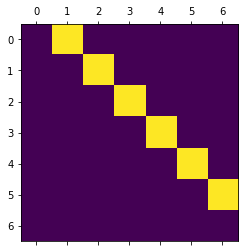

In [143]:
def plot_numbers(ax, next_nodes, sort_indices):
    ax.matshow(next_nodes[sort_indices][:, sort_indices], cmap="viridis")
    ax.grid(False)
    
fig = plt.figure(1, figsize=(4, 4))
ax = fig.add_subplot()
plot_numbers(ax, target_graph["next_nodes"], sort_indices)

In [178]:
NUM_NODES_TRAIN = (10,15)
NUM_NODES_VAL = (100,130)

class SampleGenerator(keras.utils.Sequence):

    def __init__(self, num_minmax, epoch_len):
        self.num_minmax = num_minmax
        self.epoch_len = epoch_len

    def __len__(self):
        return self.epoch_len #number of gradient descent steps per epoch

    def __getitem__(self, _index):
        inp, tar, _ = make_example(self.num_minmax)
        return inp, tar

Define a model. We only have node inputs which are the numbers to sort. For each node, we want to predict the probability of being the "start" node (i.e. the node with the smallest number). For each edge we want to predict successor in a sorted linked list. We use a very simple GNN with only node states. Edge predictions are done on pairs of node states. 

We don't use global attributes for in- and output.

In [201]:
#a feedforward layer
def make_ff_layer(config):
    return keras.Sequential([
            layers.Dense(config["latent_dim"], activation="relu"),
            layers.Dense(config["latent_dim"]),
            layers.LayerNormalization()])

def make_GNN(config):
    
    #define the inputs
    #note: keras inputs have their batch size omitted in "shape"
    V = keras.Input(shape=(1), name="nodes") 
    
    n = tf.shape(V)[0]
    
    #layers
    node_encoder = make_ff_layer(config)
    node_messager = make_ff_layer(config)
    node_updater = make_ff_layer(config)
    node_decoder = layers.Dense(1)
    edge_decoder = keras.Sequential([
            layers.Dense(config["latent_dim"], activation="relu"),
            layers.Dense(1)])
    
    #step 1: encode
    #transform each node (dim=3) and edge (dim=1) to a latent embedding of "latent_dim"
    V_enc = node_encoder(V)
    
    start_node = []
    next_nodes = []
    
    #step 2: message passing
    for _ in range(config["message_passing_iterations"]):
        
        #the graph is fully connected, i.e. each node sends 
        #to all other nodes except itself 
        V_message = node_messager(V_enc)
        V_message = (tf.reduce_sum(V_message, axis=0, keepdims=True) - V_message) 
        V_message /= tf.cast(n-1, dtype=V_message.dtype)
        
        #update all nodes based on current state and aggregated edge states
        V_concat = tf.concat([V_enc, V_message], axis=-1)
        V_enc = node_updater(V_concat)
        
        #decoding (after each iteration to evaluate performance over time)
        #for this GNN, we need node and edge predictions
        #for nodes, use the refined embeddings from message passing above:
        start_node_probs = node_decoder(V_enc)
        #remove "1" dimensions
        start_node_probs = tf.squeeze(start_node_probs)
        #decide for one start node
        start_node_probs = tf.nn.softmax(start_node_probs) 

        #for edges, use the respective pair of node embeddings (we did not use explicit edge embeddings)
        #organize edges as follows:
        #<n edges from v_1>, <n edges from v_2>, ..., <n edges from v_n>
        #we do not exclude self loops for simplicity
        V_tile = tf.tile(V_enc, [n,1]) #abc -> (abc abc ... abc) 
        V_rep = tf.repeat(V_enc, tf.ones(n,dtype=tf.int32)*n, axis=0) #abc -> (aa..a  bb..b  cc..c) 
        next_node_probs = edge_decoder(tf.concat([V_tile, V_rep], axis=-1))
        next_node_probs = tf.reshape(next_node_probs, (n,n))
        #for each node, decide for one "next" node
        next_node_probs = tf.nn.softmax(next_node_probs)

        #manually set diagonals to 0 (exclude self loops) and rescale
        next_node_probs -= tf.linalg.diag(tf.linalg.diag_part(next_node_probs))
        next_node_probs /= tf.reduce_sum(next_node_probs, axis=-1, keepdims=True)
        
        start_node.append(start_node_probs)
        next_nodes.append(next_node_probs)
        
    outputs = []
    outputs.append(layers.Lambda(lambda x: x, name="start_node")(tf.stack(start_node)))
    outputs.append(layers.Lambda(lambda x: x, name="next_nodes")(tf.stack(next_nodes)))
    
    model = keras.Model(inputs=[V], 
                        outputs=outputs)

    return model    

In [202]:
config = {
    "message_passing_iterations" : 5,
    "latent_dim" : 16
}

NUM_EPOCHS = 5

train_gen = SampleGenerator(NUM_NODES_TRAIN, 1000)
val_gen = SampleGenerator(NUM_NODES_VAL, 50)

GNN = make_GNN(config)

cee = tf.keras.losses.CategoricalCrossentropy()
acc_first_ = tf.keras.metrics.CategoricalAccuracy()
acc_next_ = tf.keras.metrics.CategoricalAccuracy()

def cee_last_iteration(y_true, y_pred):
    #loss = 0
    #for i in range(config["message_passing_iterations"]):
   #     loss += cee(y_true, y_pred[i]) #compute loss for all iterations
    #return loss / config["message_passing_iterations"]
    return cee(y_true, y_pred[-1])

def acc_first(y_true, y_pred):
    return acc_first_(y_true, y_pred[-1])

def acc_next(y_true, y_pred):
    return acc_next_(y_true, y_pred[-1])

GNN.compile(loss= {"start_node" : cee_last_iteration,
                "next_nodes" : cee_last_iteration}, 
            optimizer=optimizer, 
            metrics={"start_node" : acc_first,
                "next_nodes" : acc_next})

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

#takes ~2min on GPU
#note that this is unneccessarily long since we don't use batching
#to keep the code simple
history = GNN.fit(train_gen,
                    validation_data=val_gen,
                    epochs = NUM_EPOCHS,
                    verbose = 1)

Epoch 1/5
1000/1000 [==============================] - 8s 8ms/step - loss: 1.5224 - start_node_loss: 0.4239 - next_nodes_loss: 1.0985 - start_node_acc_first: 0.9297 - next_nodes_acc_next: 0.3774 - val_loss: 4.1235 - val_start_node_loss: 1.0257 - val_next_nodes_loss: 3.0978 - val_start_node_acc_first: 0.9756 - val_next_nodes_acc_next: 0.4806
Epoch 2/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6011 - start_node_loss: 0.0712 - next_nodes_loss: 0.5299 - start_node_acc_first: 0.9831 - next_nodes_acc_next: 0.4928 - val_loss: 4.5540 - val_start_node_loss: 1.1510 - val_next_nodes_loss: 3.4030 - val_start_node_acc_first: 0.9875 - val_next_nodes_acc_next: 0.5136
Epoch 3/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.5005 - start_node_loss: 0.0668 - next_nodes_loss: 0.4337 - start_node_acc_first: 0.9897 - next_nodes_acc_next: 0.5225 - val_loss: 4.5930 - val_start_node_loss: 0.8125 - val_next_nodes_loss: 3.7805 - val_start_node_acc_first: 0.9914 - val

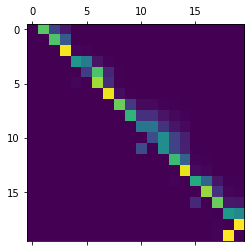

In [203]:
input_graph, _, sort_indices = make_example((20,21))
fig = plt.figure(1, figsize=(4, 4))
ax = fig.add_subplot()
start_node, next_nodes = GNN(input_graph)
start_node_probs = start_node[-1]
next_node_probs = next_nodes[-1]
plot_numbers(ax, next_node_probs.numpy(), sort_indices)

### Decode a sorted list

Start at the predicted start node. Greedily follow to the next unvisited node with highest probabilty.

In [204]:
def decode_sorting(numbers, start_node_probs, next_node_probs):
    print("unsorted numbers:", numbers)
    start = np.argmax(start_node_probs)
    sort_indices = [start]
    unvisited = np.ones(len(numbers))
    unvisited[start] = 0
    current_node = start
    for i in range(len(numbers)-1):
        probs = unvisited * next_node_probs[current_node]
        current_node = np.argmax(probs)
        unvisited[current_node] = 0
        sort_indices.append(current_node)
    print("sorted numbers:", numbers[sort_indices])

decode_sorting(input_graph["nodes"], start_node_probs, next_node_probs)

unsorted numbers: [0.38763288 0.55068355 0.63585386 0.30715171 0.30430239 0.96569684
 0.67923487 0.7508123  0.60724764 0.76464254 0.1989764  0.80916076
 0.60731028 0.66005793 0.50115385 0.1531311  0.11513575 0.98302534
 0.33980373 0.17662113]
sorted numbers: [0.11513575 0.1531311  0.17662113 0.1989764  0.30430239 0.33980373
 0.38763288 0.50115385 0.55068355 0.60724764 0.63585386 0.66005793
 0.67923487 0.7508123  0.76464254 0.80916076 0.96569684 0.98302534
 0.60731028 0.30715171]


General lists of any real numbers can be handled by rescaling to $[0,1]$

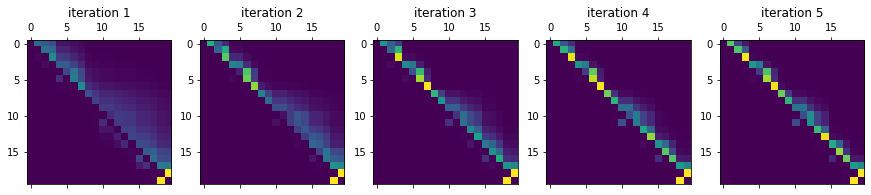

In [205]:
# sorting over time: A visualization of each iteration
ncols = 5
nrows = int(np.ceil(config["message_passing_iterations"]/ncols))

fig = plt.figure(1, figsize=(15, 8))
for i in range(config["message_passing_iterations"]):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.set_title("iteration "+str(i+1))
    start_node_probs = start_node[i]
    next_node_probs = next_nodes[i]
    plot_numbers(ax, next_node_probs.numpy(), sort_indices)